# Setup

Ensure all dependencies are installed.


In [1]:
%pip install -U -r requirements.txt

Looking in links: https://download.pytorch.org/whl/torch/, https://download.pytorch.org/whl/torchvision/
  Using cached torch_tb_profiler-0.4.3-py3-none-any.whl.metadata (1.4 kB)
  Using cached numpy-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached lightning-2.5.0.post0-py3-none-any.whl.metadata (40 kB)
INFO: pip is looking at multiple versions of lightning to determine which version is compatible with other requirements. This could take a while.
  Using cached lightning-2.5.0-py3-none-any.whl.metadata (40 kB)
  Using cached lightning-2.4.0-py3-none-any.whl.metadata (38 kB)
Using cached torch_tb_profiler-0.4.3-py3-none-any.whl (1.1 MB)
Note: you may need to restart the kernel to use updated packages.


# AI Model


## Settings

Our main settings are found in the config.yaml file, but you can also modify values here for convenience.


In [1]:
from pole_gen.models import UtilityPoleLabel
import numpy as np
import random
import warnings
import torch
from utils.logging import warning_format
from utils.config import *

CLASSES: list = [l.name for l in UtilityPoleLabel]
N_CLASSES: int = len(CLASSES)
torch.set_float32_matmul_precision("medium")

warnings.formatwarning = warning_format

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {device}")
else:
    device = torch.device("cpu")
    warnings.warn("CUDA is not available. Running on CPU.")
    print(f"Using device: {device}")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
print(f"Seed: {SEED}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using device: cuda
Seed: 42


## Load Training Data

This data is procedurally generated.


In [2]:
import os
from pole_gen.data import generate_data
from models.dataset import PointCloudDataset
from torch.utils.data import DataLoader

needs_validation = False
if not os.path.exists(TRAIN_DATA_PATH) or len(os.listdir(TRAIN_DATA_PATH)) == 0:
    print("Directory is empty or does not exist. New testing data will be generated.")
    generate_data(
        n_samples=TRAIN_DATA_SIZE,
        n_points=N_POINTS,
        out_dir=TRAIN_DATA_PATH,
        jitter=0.02,
    )
    needs_validation = True
else:
    print("Data directory found. Using existing training data.")

file_paths = [os.path.join(TRAIN_DATA_PATH, f) for f in os.listdir(TRAIN_DATA_PATH)]
train_dataset = PointCloudDataset(
    file_paths=file_paths,
    n_points=N_POINTS,
    n_classes=N_CLASSES,
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=TRAIN_DATA_BATCH_SIZE,
    shuffle=True,
    num_workers=TRAIN_DATA_WORKERS,
    persistent_workers=True,
)

if needs_validation:
    train_dataset.validate()

print(f"Training dataset size: {len(train_dataset)}")

Data directory found. Using existing training data.
Training dataset size: 65536


## Load Testing & Validation Data

This data is manually labeled, real-world laser scanned data. We will fetch this remotely if needed.


In [3]:
import os
from electrical_poles.data import download_data
from models.dataset import PointCloudDataset
from torch.utils.data import DataLoader

needs_validation = False
if not os.path.exists(TEST_DATA_PATH) or len(os.listdir(TEST_DATA_PATH)) == 0:
    print(
        "Testing data directory is empty or does not exist. New testing data will be downloaded."
    )
    download_data(out_dir=TEST_DATA_PATH, n_points=N_POINTS)
    needs_validation = True
else:
    print("Testing data directory found. Using existing testing data.")

real_data = PointCloudDataset(
    file_paths=[os.path.join(TEST_DATA_PATH, f) for f in os.listdir(TEST_DATA_PATH)],
    n_points=N_POINTS,
    n_classes=N_CLASSES,
)

if needs_validation:
    real_data.validate()

# Split the real data into test and validation datasets
valid_size = int(VALID_DATA_SPLIT * len(real_data))
test_dataset, valid_dataset = torch.utils.data.random_split(
    real_data, [len(real_data) - valid_size, valid_size]
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=TEST_DATA_BATCH_SIZE,
    shuffle=False,
    num_workers=TEST_DATA_WORKERS,
    persistent_workers=True,
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=VALID_DATA_BATCH_SIZE,
    shuffle=False,
    num_workers=VALID_DATA_WORKERS,
    persistent_workers=True,
)

del real_data

print(f"Testing dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")

Testing data directory found. Using existing testing data.
Testing dataset size: 73
Validation dataset size: 18


## Training


In [4]:
import torch
from ai.pointnet_seg.model import PointNetSeg
import os
import pytorch_lightning as L

data_path = "data/pointnet"
model_fname = "bestmodel"
log_fname = "log.csv"

segmenter = PointNetSeg(n_classes=N_CLASSES)

model_path = os.path.join(data_path, model_fname)
log_path = os.path.join(data_path, log_fname)

try:
    segmenter.load_state_dict(torch.load(f"{model_path}.pth"))
    print("Model loaded")
except FileNotFoundError:
    print("Training new model...")
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    trainer = L.Trainer(
        fast_dev_run=True,
        max_epochs=15,
        default_root_dir=data_path,
    )
    trainer.fit(
        model=segmenter,
        train_dataloaders=train_dataloader,
        val_dataloaders=valid_dataloader,
    )
    trainer.test(model=segmenter, dataloaders=test_dataloader)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Training new model...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | pointnet   | PointNet   | 2.8 M  | train
1 | mlp1       | MLP_CONV   | 558 K  | train
2 | mlp2       | MLP_CONV   | 131 K  | train
3 | mlp3       | MLP_CONV   | 33.2 K | train
4 | conv       | Conv1d     | 1.0 K  | train
5 | logsoftmax | LogSoftmax | 0      | train
6 | criterion  | NLLLoss    | 0      | train
--------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
14.113    Total estimated model params size (MB)


Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │      0.0272216796875      │
│         test_iou          │   0.004310990683734417    │
│         test_loss         │    2.0786383152008057     │
└───────────────────────────┴───────────────────────────┘

## Testing

Test our data on our real-world dataset.


In [5]:
import pytorch_lightning as L

trainer = L.Trainer(default_root_dir=data_path)
trainer.test(model=segmenter, dataloaders=test_dataloader)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.0314239077270031     │
│         test_iou          │   0.005259429570287466    │
│         test_loss         │     2.079857110977173     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.079857110977173,
  'test_acc': 0.0314239077270031,
  'test_iou': 0.005259429570287466}]

# Demo

A little section here to show its labeling in action!


Accuracy: 88.48%


Exception ignored in: <function _ConnectionBase.__del__ at 0x7fe26c1ceb90>
Traceback (most recent call last):
  File "/home/jovyan/research-project-python/.conda/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/home/jovyan/research-project-python/.conda/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


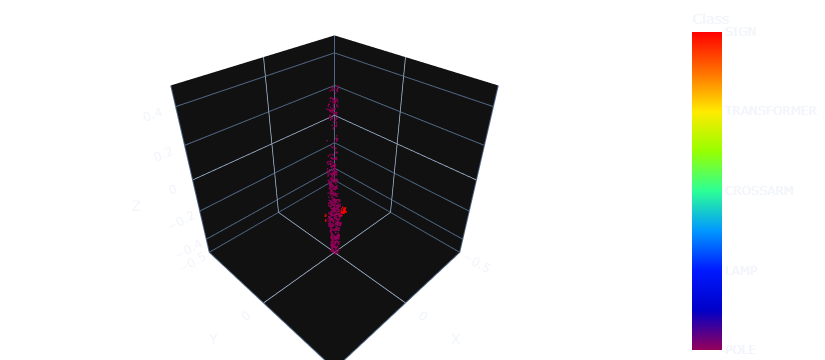

In [7]:
import numpy as np
import open3d as o3d
from utils.plot import plot_cloud
from utils.string import format_accuracy

segmenter.eval()
with torch.no_grad():
    inputs, labels = test_dataset[np.random.randint(0, len(test_dataset))]
    inputs = inputs.float()
    outputs, __, __ = segmenter(inputs.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)

pc = o3d.t.geometry.PointCloud()
pc.point.positions = o3d.core.Tensor(
    inputs.squeeze(0).numpy(), dtype=o3d.core.Dtype.Float32
)
pc.point.labels = predicted.squeeze(0).numpy()

accuracy = (predicted == labels).sum().item() / N_POINTS
print(f"Accuracy: {format_accuracy(accuracy)}")
plot_cloud(pc, xaxis=[-0.5, 0.5], yaxis=[-0.5, 0.5], zaxis=[-0.5, 0.5])

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/